In [21]:
import time 
start = time.time()

# import os
# os.environ["pRT_input_data_path"] = "/home/mvasist/pRT/input_data"

import numpy as np
import pylab as plt
import matplotlib.ticker as mticker
import matplotlib

import pymultinest

plt.rcParams['figure.figsize'] = (10, 6)
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc 
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.retrieval.models import emission_model_diseq, PT_ret_model

from sbi.inference import SNRE_A, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi.types import Array, OneOrMore, ScalarFloat
from sbi.analysis import pairplot

import torch
import pandas as pd
import sys
import csv

In [13]:
#saved samples 
# ss=[]
# ln=[]

# for i in ['100']:  #'12', '50', 
#     s= pd.read_csv( '/home/mvasist/samples/' + i +'ksamples_e76__SBI_100ksim_gammaTequG.csv')   
#     l= pd.read_csv( '/home/mvasist/samples/' + i +'klnprob_e76__SBI_100ksim_gammaTequG.csv')
#     ss.append(s.values)
#     ln.append(l.values)

# sss= np.vstack(ss)
# lnn= np.vstack(ln)

# df_samples = pd.DataFrame(sss)
# df_lnprob = pd.DataFrame(lnn)

df_samples = pd.read_csv('/home/mvasist/samples_new/samples_testh5.csv', header=None, index_col=0)
df_lnprob = pd.read_csv('/home/mvasist/samples_new/lnprob_testh5.csv', header=None, index_col=0)
# samples = torch.tensor(np.array(s),dtype=torch.float32)
# ll = torch.tensor(np.array(l),dtype=torch.float32)



In [34]:
df_samples

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,,,,,,,,,,,,,
0,1.239131,-0.299049,-1.631109,-1.807071,1.256726,2.035482,1.196187,1983.31540,0.262201,0.117130,0.321350,1.111369,0.999750
1,0.643579,-0.628549,-2.924959,-2.064781,4.482878,2.572943,1.493766,1582.28550,0.291111,0.474755,0.158950,1.280876,0.077832
2,0.123752,-1.228750,2.950026,0.298390,-2.934258,4.036590,1.957439,670.00806,0.463740,0.634719,0.254620,1.025431,0.273579
3,1.200598,-1.141217,2.940505,-2.597483,-2.638593,2.335462,0.782814,858.76880,0.004642,0.460017,0.320582,1.241939,0.212500
4,0.323893,-0.088919,1.133800,3.236947,-2.728816,3.108116,1.636257,936.07760,0.564157,0.303949,0.704688,1.043150,0.927028
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.113461,1.172937,-0.615088,-2.322224,-2.525252,3.446907,1.379638,545.28530,0.223016,0.151736,0.534245,1.944637,0.881405
996,0.951037,-0.944195,-5.493750,2.969945,2.287537,4.381088,1.091111,593.51380,0.058538,0.497605,0.913135,1.017886,0.963902
997,0.206407,-0.413662,2.556459,-0.834114,-3.043806,3.400868,1.847396,1543.62160,0.443765,0.891338,0.519966,1.364108,0.976722


In [14]:
df_lnprob

,1
0,
0,-16.839895
1,-17.071657
2,-16.872255
3,-16.904593
4,-16.977661
...,...
995,-16.972850
996,-16.950132
997,-16.809940


In [3]:
def color(a):
    mini = min(df_lnprob[1])
    maxi = max(df_lnprob[1])
    
    return (a-mini)/(maxi-mini)*100

In [41]:
pressures = np.logspace(-6, 2, 154)

In [19]:
observation_PT = torch.load('/home/mvasist/scripts_new/observation/obs_PT.pt') 
pressures_obs = observation_PT[0]
temperatures_obs = observation_PT[1]

In [56]:
def calc_temp(T3,T1,T2,log_delta,alpha,T_int,FeH,CO):
    
    T3 = ((3./4.*T_int**4.*(0.1+2./3.))**0.25)*(1.0-T3)
    T2 = T3*(1.0-T2)
    T1 = T2*(1.0-T1)
    delta = ((10.0**(-3.0+5.0*log_delta))*1e6)**(-alpha)
    
    temperatures = PT_ret_model(np.array([T1,T2,T3]), \
                            delta,
                            alpha,
                            T_int,
                            pressures,
                            FeH,
                            CO,
                            conv=True)
    
    return temperatures 
    

In [57]:
temperatures1 = calc_temp(0,0,0,0, 1, 300, -1.5, 0.1)
temperatures2 = calc_temp(1,1,1,1, 2, 2300, 1.5, 1.61)

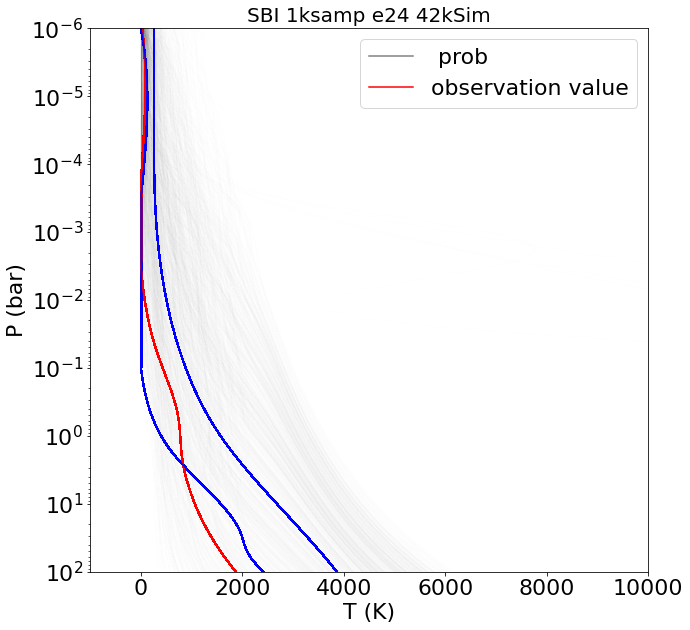

it takes: 0.33094088633855184 min


In [59]:
# creating P-T profile for each - takes around 10 min
temp = []
cc=[]
matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, figsize=(10,10))
plt.title('SBI 1ksamp e24 42kSim', fontsize=20)
start = time.time()
c2=0
c4=0

for row in np.arange(0,999):  #np.random.randint(0,999,1000)
    lnprob = df_lnprob[1][row] 
    cc.append(color(lnprob)) 
    
    T3,T1,T2,log_delta,alpha,T_int,FeH,CO = [df_samples[col][row] for col in [9,10,11,13,12,8,2,1]]
    temperatures = calc_temp(T3,T1,T2,log_delta,alpha,T_int,FeH,CO)
    
    ax.plot(temperatures, pressures, c='grey', alpha=0.002)
    ax.plot(temperatures_obs, pressures_obs, c= 'red', label = 'observation value' if c4 == 0 else "")
    c4+=1
    ax.plot([0], [0], c= 'grey', label = " prob " if c2 == 0 else "")
    c2+=1
    plt.plot(temperatures1, pressures, c= 'blue')
    plt.plot(temperatures2, pressures, c= 'blue')
    plt.yscale('log')
    plt.ylim([1e2, 1e-6])
    plt.xlim([-1000,10000])
    plt.xlabel('T (K)')
    plt.ylabel('P (bar)')
    temp.append(temperatures)
#plt.savefig('/home/mvasist/results/SNRE/PT_profile/SBI_162ksamp_100kSim.png')
handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0]]  #, handles[3], handles[1]]
labels = [labels[1], labels[0]]  #, labels[3], labels[1]]
ax.legend(handles,labels)
# plt.legend()
plt.show()

end =time.time()
print('it takes: '+ str((end-start)/60) + ' min')

In [ ]:
# plt.hist(cc,bins=1000)
# plt.axvline(95,c='r')
# plt.axvline(85,c='r')